# Seismic Cubeset and CropBatch tutorial

This notebook demonstrates how to work with `SeismicCubeset`, which is merely a container for `SeismicGeometries` and `Horizons`, and shows pipeline of loading actual data into batches. You will learn how to:

- organize loads of cubes and horizons into one entity
- generate points close to one of the horizons in 3D cube space
- load seismic images and create masks near generated points
- apply augmentations for both data and labels

In [1]:
%load_ext autoreload
%autoreload 2

# All the necessary imports
import sys
import numpy as np
from glob import glob

sys.path.append('..')
from seismiqb.batchflow import D, P, R, FilesIndex, Pipeline
from seismiqb import SeismicCubeset, plot_image 

# Seismic Cubeset

As was mentioned before, an instance of `SeismicCubeset` is merely a container to hold cubes and horizons together. It is initialized from a list of cube paths, and under the hood instances of `SeismicGeometry` are created:

In [2]:
cubes = [
    '/data/seismic/CUBE_1/E_anon.hdf5',
    '/data/seismic/CUBE_3/P_cube.hdf5'
]

dsi = FilesIndex(path=cubes, no_ext=True)
dataset = SeismicCubeset(dsi)

print(dataset)

Seismic Cubeset with 2 cubes:
    E_anon
    P_cube



We need to use `load_geometries` method to actually infer cube info:

In [3]:
dataset.load_geometries()

print(dataset)

Seismic Cubeset with 2 cubes:
    Inferred geometry for E_anon.hdf5: (2563x1409x1501)
    Inferred geometry for P_cube.hdf5: (2737x2599x2001)



As we can see, now each cube knows about its shape, as well as lots of other statistics which you can check in [the very first tutorial on `SeismicGeometry`](./01_Geometry.ipynb).

To add horizons for each cube, we create a mapping from `cube_name` to list of horizon paths, and pass it to the `create_labels` method. After that, visual representation of `dataset` shows them too:

In [4]:
horizons = {
    dataset.indices[0]: glob('/data/seismic/CUBE_1/RAW/*'),
    dataset.indices[1]: glob('/data/seismic/CUBE_3/RAW/prb*')
}

dataset.create_labels(horizons)

print(dataset)

Seismic Cubeset with 2 cubes:
    Inferred geometry for E_anon.hdf5: (2563x1409x1501):
        etp_PK1_anon
        etp_BP4_anon
        etp_BP6_anon
        etp_BP9_anon
        etp_BP10_anon
        etp_BP12_anon
        etp_BP14_anon
        etp_BP16_anon
        etp_B_anon
    Inferred geometry for P_cube.hdf5: (2737x2599x2001):
        prb_G_anon
        prb_M_anon
        prb_B_anon
        prb_T_ALL_anon



The last but not least, sampler. Sampler is an entity that generates points in following format:

- each point is 4-dimensional
- the first entry is name of the cube that this point belongs to
- the last three are coordinates in the cube, scaled to $[0, 1]$ range along every axis
- by default, sampler generates points close to the set of the horizons for each cube

During the model train, we sample points and use it as anchor for crop location, that is cut from actual seismic cube. Method `show_slices` allows to visualize actually generated crops of data given the shape of desired crops:

Example of sampled points:
 [['E_anon' 0.5892070072191689 0.6453749486828995 0.3501055769018322]
 ['P_cube' 0.6467840251599389 0.05713673012910414 0.5894017863378407]
 ['P_cube' 0.452336037773338 0.34426629253398283 0.2824054124356153]]


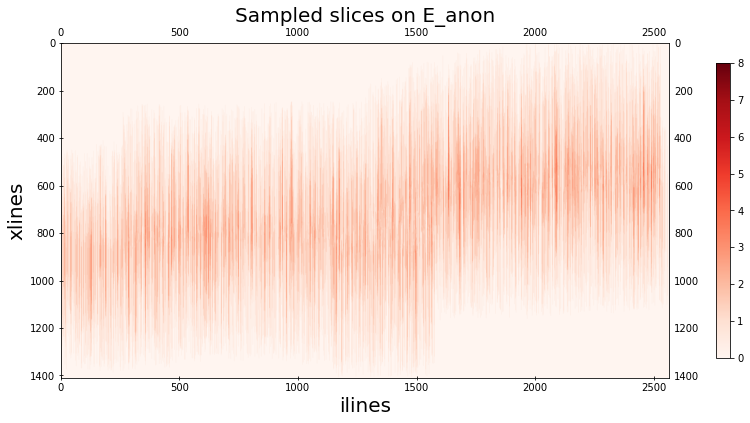

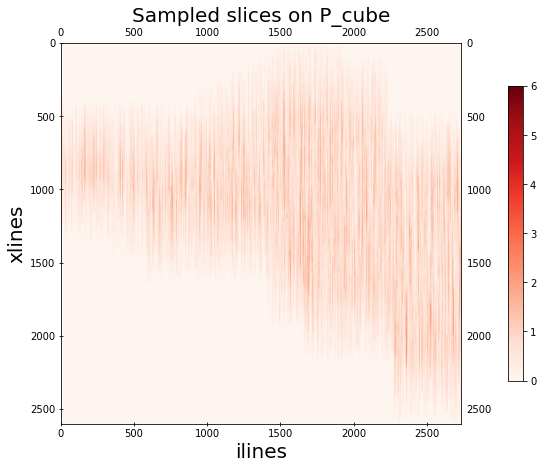

In [5]:
dataset.create_sampler()

print('Example of sampled points:\n', dataset.sampler.sample(3))

for i, idx in enumerate(dataset.indices):
    dataset.show_slices(idx=i, shape=(1, 512, 512),
                        cmap='Reds', interpolation='bilinear')

# CropBatch

All of our research is organized with the help of [**BatchFlow** library](https://github.com/analysiscenter/batchflow), which allows us to:

- define pipelines that set the sequence of actions to be performed on generated batches of data. Each action can be done in a multi-threading or multi-processing way, where different threads/processes work with various individual batch items
- create complex neural networks with just a few lines of code
- do hyperparameter research 

To load data according to sampler, we:
- create crop locations, based on generated (sampled) points of desired shape. Note that it does not load anything from disk: only positions are created

- heavy lifting of disk I/O is performed by `load_cubes`, that takes positions (created by `crop`) and actually gets seismic data

- `create_masks` action generates segmentation mask for the crop location by adding all of the horizons on it

In [6]:
demo_pipeline = (
    Pipeline()
    .make_locations(points=D('sampler').sample(2), shape=(1, 512, 512))
    .load_cubes(dst='images')
    .create_masks(dst='masks')
) << dataset

batch = demo_pipeline.next_batch(D('size'))

All the created components (`images`, `masks`) can be accessed via dotted notation: `batch.images` and `batch.masks`. Following visualization shows them on separate graphs:

Seismic image and mask on E_anon:


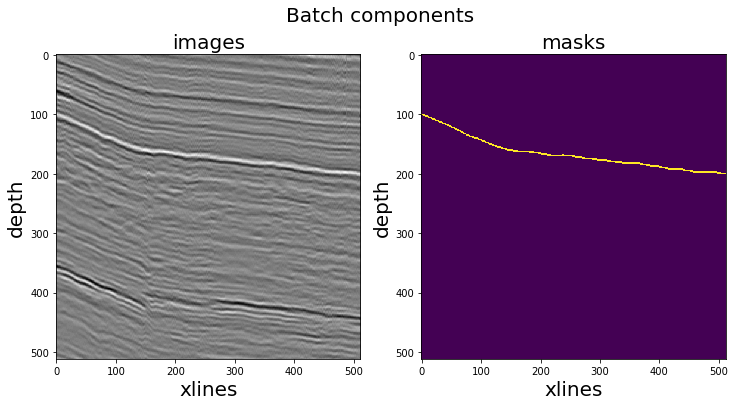

Seismic image and mask on E_anon:


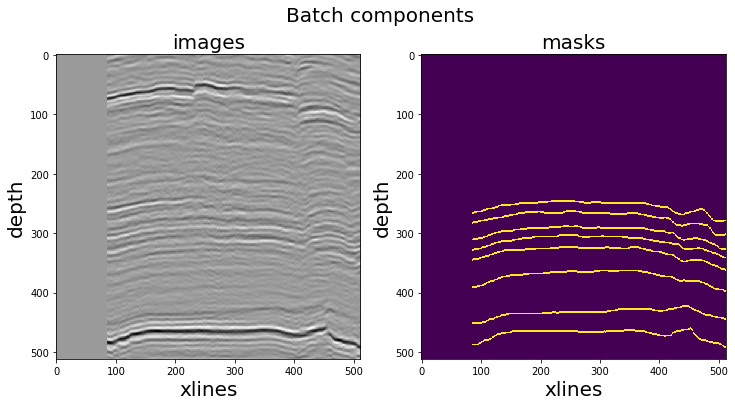

In [7]:
for idx in range(2):
    print(f'Seismic image and mask on {batch.indices[idx][:-10]}:')
    batch.plot_components('images', 'masks', mode='separate', idx=idx, y=.9)

In order to train a robust model, we must diversify our dataset with wealth of data augmentations: that helps to prevent overfitting and make model generalize better to unseen inputs. Many of the augmentations are already implemented as part of `CropBatch`:

* `transpose`: by default, `crop`, `load_cubes`, `create_mask` get data in `(iline, xline, h)` format with `iline` being used as image-channel, yet most of the following augmentations can be computed way more efficiently if the channel axis is the last. Transposing allows us to permute the order before applying augmentations
* `scale`: as different cubes have different ranges of possible values, it is usually a good idea to transform each of them to a fixed range. Under the hood, minimum and maximum values for each cube are used
* `additive_noise`, `multiplicative_noise`: modify each entry in `src` by adding zero-mean noise or multiplying by values with mean at 1

#### All of the next augmentations are applied to the first two axes, so `rotate_axis` is what you want to do before them!
* `rotate`, `scale_2d`: rotate image around its center, zoom in or zoom out of it
* `cutout_2d`: zero-out patches of first two axes
* `affine_transform`, `perspective_transform`: change basis to move 3 (4 in case of perspective transform) points to different location 
* `elastic_transform`: slightly jitter the indexing grid of the first two axes of `src`
* `bandwidth_filter`: keep only desired range of frequences

In [8]:
demo_pipeline = (
    Pipeline()
    # Load data
    .make_locations(points=D('sampler').sample(4), shape=(1, 512, 512))
    .load_cubes(dst='images')
    .create_masks(dst='masks')
    .normalize(mode='minmax', src='images')
    .transpose(src=['images', 'masks'], order=(1, 2, 0))
    
    # Images only augmentations:
    .additive_noise(scale=0.05,
                    src='images', dst='images_anoise')
    .multiplicative_noise(scale=0.05,
                          src='images', dst='images_mnoise')
    .cutout_2d(patch_shape=P(R('uniform', 10, 20, size=2)), n=P(R('uniform', 10, 20)),
               src='images', dst='images_cutout')
    .bandwidth_filter(lowcut=0.09, highcut=0.5, fs=2,
                      src='images', dst='images_bfilter')

    # Images and masks augmentations: 
    .rotate(angle=30,
            src=['images', 'masks'], dst=['images_rotate', 'masks_rotate'])
    .scale_2d(scale=2,
              src=['images', 'masks'], dst=['images_scale', 'masks_scale'])
    .affine_transform(alpha_affine=P(R('uniform', 0, 30)),
                      src=['images', 'masks'], dst=['images_affine', 'masks_affine'])
    .perspective_transform(alpha_persp=P(R('uniform', 0, 30)),
                           src=['images', 'masks'], dst=['images_perspective', 'masks_perspective'])
    .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                       src=['images', 'masks'], dst=['images_elastic', 'masks_elastic'])

    .transpose(src=['images', 'masks'], order=(2, 0, 1))
) << dataset

batch = demo_pipeline.next_batch(D('size'))

Seismic data and its augmented counterpart:

Seismic image and `anoise`-version on P_cube:


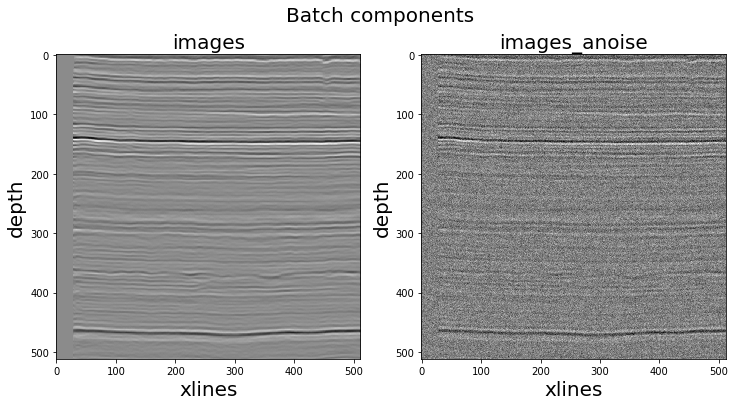

Seismic image and `mnoise`-version on E_anon:


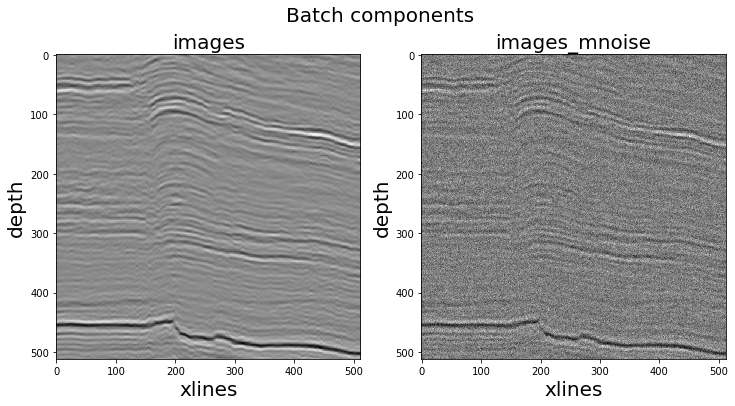

Seismic image and `cutout`-version on E_anon:


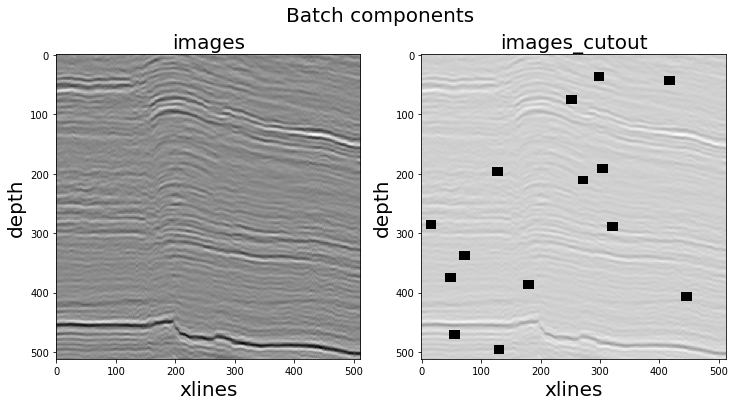

Seismic image and `bfilter`-version on E_anon:


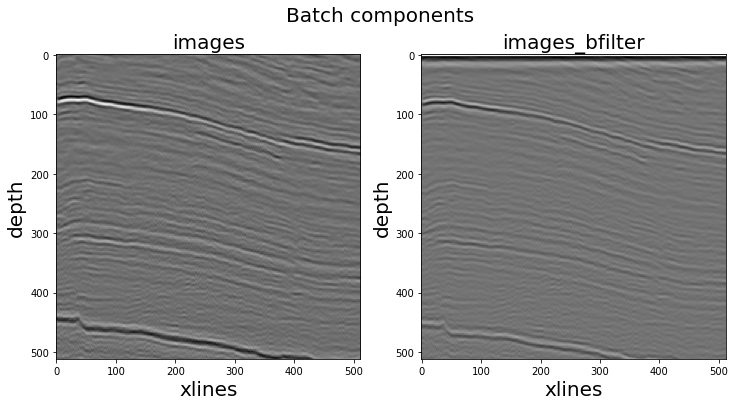

In [9]:
augmentations = ['anoise', 'mnoise', 'cutout', 'bfilter']

for aug in augmentations:
    idx = np.random.randint(4)
    print(f'Seismic image and `{aug}`-version on {batch.indices[idx][:-10]}:')

    batch.plot_components('images', f'images_{aug}', mode='separate', idx=idx, y=0.9, cmap=['gray']*2)

Seismic data with masks painted over it and the augmented counterpart:

Seismic image and `rotate`-version on E_anon:


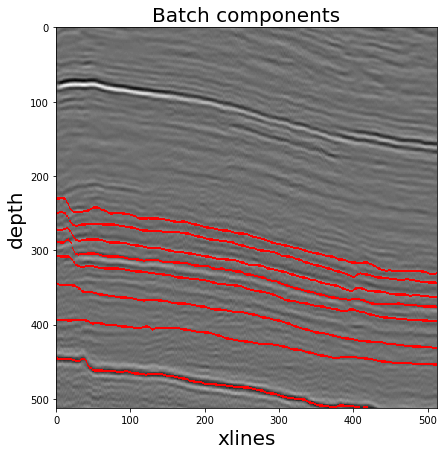

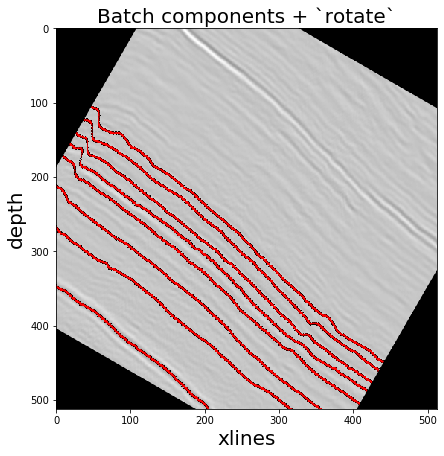

Seismic image and `scale`-version on P_cube:


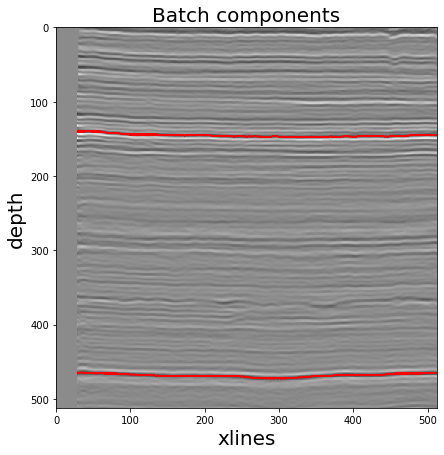

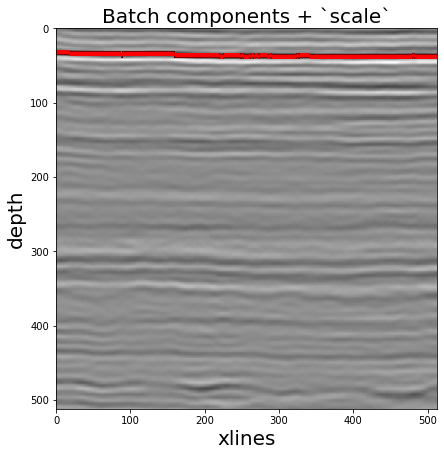

Seismic image and `affine`-version on E_anon:


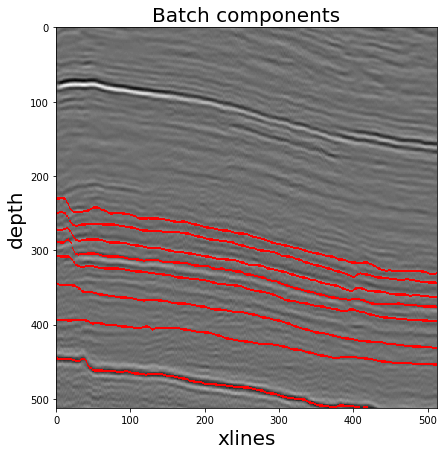

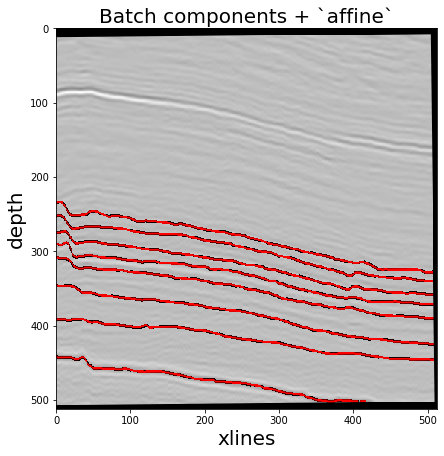

Seismic image and `perspective`-version on E_anon:


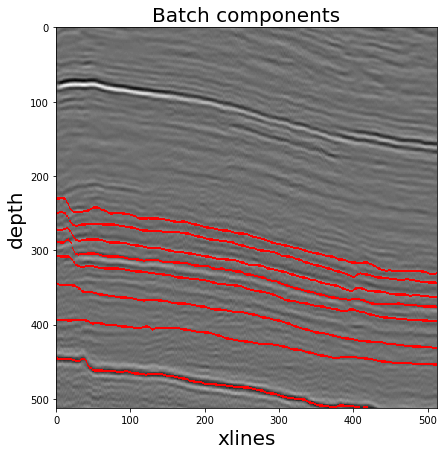

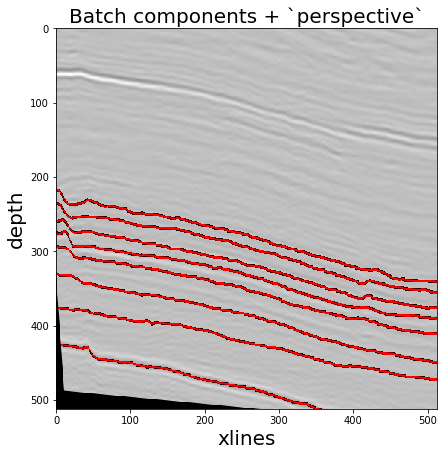

Seismic image and `elastic`-version on P_cube:


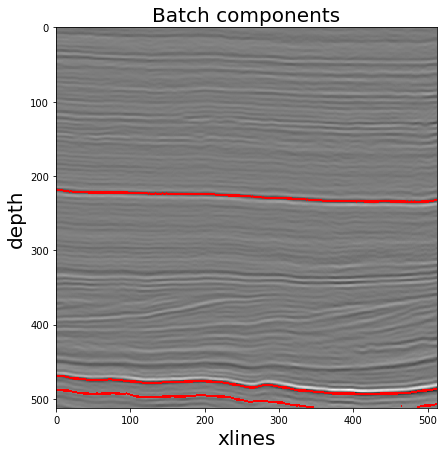

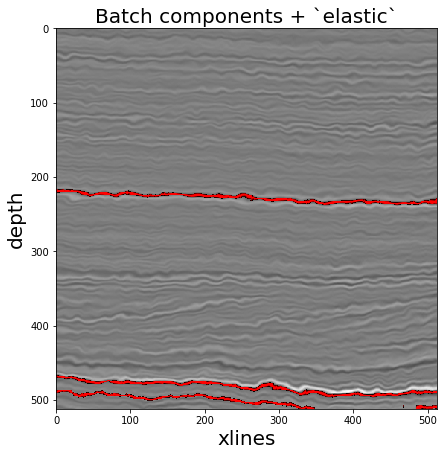

In [10]:
augmentations = ['rotate', 'scale', 'affine', 'perspective', 'elastic']

for aug in augmentations:
    idx = np.random.randint(4)
    print(f'Seismic image and `{aug}`-version on {batch.indices[idx][:-10]}:')

    batch.plot_components('images', 'masks', mode='overlap', idx=idx, y=1)
    batch.plot_components(f'images_{aug}', f'masks_{aug}', mode='overlap',
                          title=f'Batch components + `{aug}`', idx=idx, y=1)